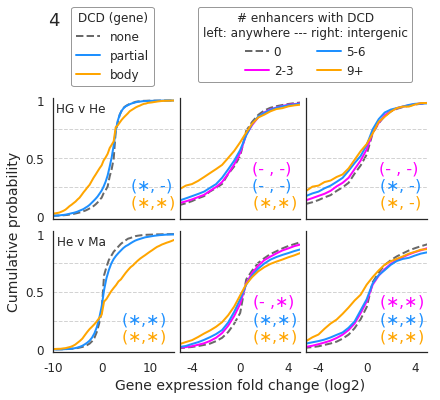

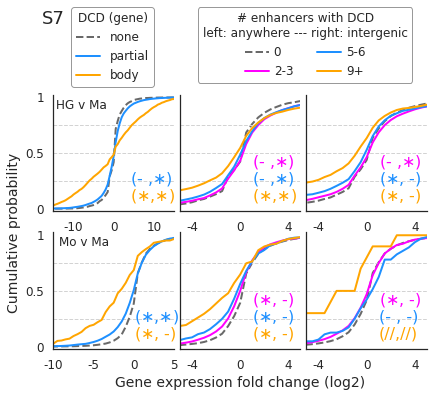

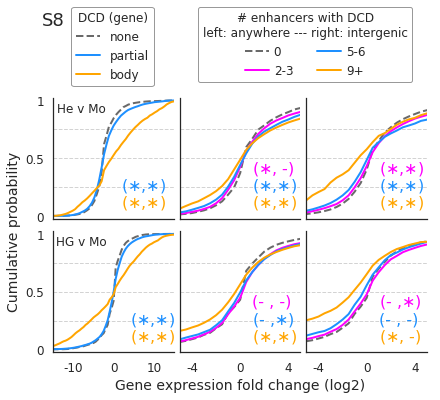

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot CDF of genes overlapping
# with HSPs in different ways
# (full, partial, enhancer etc.)

date = '20180921'

run_dcd_body_enh_cdf = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/github/project-diff-chromatin-state/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

base_out = '/TL/epigenetics2/work/pebert/cloud/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def plot_body_cdf(axis, comp, dataset, groups, cdf_step,
                  add_xticks, add_ylabel, add_legend, figure_key):
    """
    """
    sub = dataset.loc[dataset['comparison'] == comp, :].copy()
    sub.reset_index(drop=True, inplace=True)

    bins, bin_nums = generate_bins(sub, cdf_step)
    all_cdfs = dict()
    all_fc = dict()
    group_sizes = dict()
    for g, c, ls in zip([4,3,2,1],
                        ['dimgrey', 'magenta', 'dodgerblue', 'orange'],
                        ['dashed', 'solid', 'solid', 'solid']):
        if g == 3:
            continue
        
        group_data = sub.loc[sub['hit_group'] == g, 'gene_log2fc']
        group_sizes[g] = group_data.shape[0]
        all_fc[g] = group_data.values
        hist, bin_edges = np.histogram(group_data,
                                       bins=bins,
                                       density=True)
        hist = np.concatenate([[0], hist])
        cdf = np.cumsum(hist) * cdf_step
        all_cdfs[g] = cdf
        assert np.isclose(hist.sum() * cdf_step, 1., atol=1e-6), 'CDF not 1'

        axis.plot(bins, cdf,
                  lw=2, ls=ls, c=c, label=groups[g])
        
    axis.set_ylim(-0.025, 1.025)
    axis.set_yticks([0, 0.5, 1])
    axis.set_yticklabels(['0', '0.5', '1'], fontsize=12)
        
        
    axis.axhline(0.75, 0, 1, c='lightgrey',
                 ls='dashed', zorder=0, lw=1)
    axis.axhline(0.5, 0, 1, c='lightgrey',
                 ls='dashed', zorder=0, lw=1)
    axis.axhline(0.25, 0, 1, c='lightgrey',
                 ls='dashed', zorder=0, lw=1)
        
    leg_handles = []
    y_start = 0.225
    mwu = stats.mannwhitneyu
    for g, c in zip([3,2,1], ['magenta', 'dodgerblue', 'orange']):
        if g == 4:
            pass
        elif g == 3:
            continue
        else:
            cdf_bg = all_cdfs[4]
            fc_bg = all_fc[4]
            cdf_fg = all_cdfs[g]
            fc_fg = all_fc[g]
            #ks_res = stats.ks_2samp(cdf_1, cdf_0)
            #pv = ks_res[1]
            
            # factor 2 for multiple testing correction
            pv_neg = mwu(fc_bg[fc_bg < 0], fc_fg[fc_fg < 0], alternative='two-sided')[1] * 2
            pv_pos = mwu(fc_bg[fc_bg > 0], fc_fg[fc_fg > 0], alternative='two-sided')[1] * 2
            
            if pv_neg < 0.01:
                text_lab = r'($\ast$,'
            else:
                text_lab = r'(- ,'
            if pv_pos < 0.01:
                text_lab += r'$\ast$)'
            else:
                text_lab += r' -)'
            if comp == 'Mo_vs_Ma':
                axis.text(0., y_start, s=text_lab, color=c, fontsize=16)
            else:
                axis.text(4, y_start, s=text_lab, color=c, fontsize=16)
            y_start -= 0.15
        
    if comp.startswith('HG_'):
        x_min, x_max = -15, 15
        x_ticks = [-10, 0, 10]
    elif comp.startswith('Mo_'):
        x_min, x_max = -10, 5
        x_ticks = [-10, -5, 0, 5]
    else:
        x_min, x_max = -10, 15
        x_ticks = [-10, 0, 10]

    axis.set_xlim(x_min, x_max)
    if add_xticks:
        axis.set_xticks(x_ticks)
        axis.set_xticklabels(list(map(str, x_ticks)), fontsize=12)
    else:
        axis.set_xticks([])

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

    s1, s2 = comp.split('_vs_')
    axis.text(x_min + 0.75, 0.9, s='{} v {}'.format(s1, s2), fontsize=12)

    ax_leg = None
    if add_legend:
        ax_leg = axis.legend(loc='upper left',
                             bbox_to_anchor=(0.1, 1.8), fontsize=12,
                             ncol=1, edgecolor='grey', frameon=True)
        leg_tt = ax_leg.set_title('DCD (gene)', prop={'size': 12})
            
    if add_ylabel:
        ylab = axis.set_ylabel('Cumulative probability', fontsize=14)
        ylab.set_position((0, 1))
        
    fkey, ax_title = None, None
    if figure_key is not None:
        tt = axis.set_title(figure_key, fontsize=18)
        tt.set_position((0, 1.55))
            
    return axis, [ax_leg]


def plot_enh_cdf(axis, enh_type, enh_data, comp, cdf_step, add_xticks, add_xlabel, add_legend):
    
    sub = enh_data.loc[enh_data['comparison'] == comp, :].copy()
    
    bins, bin_nums = generate_bins(sub, cdf_step)
    
    enh_hist, labels, group_fc = compute_densities(sub, bins, enh_type)

    enh_colors = ['dimgrey', 'magenta', 'dodgerblue', 'orange']
    enh_style = ['dashed', 'solid', 'solid', 'solid']
    zorders = [0, 2, 2, 2]
    
    leg_handles = []
    all_cdfs = dict()
    for c, hist, lab, ls, z in zip(enh_colors, enh_hist, labels, enh_style, zorders):
        cdf = np.cumsum(hist) * cdf_step
        all_cdfs[lab[0]] = cdf
        assert np.isclose(hist.sum() * cdf_step, 1., atol=1e-6), 'CDF not 1'
        axis.plot(bins, cdf, lw=2, ls=ls, c=c, zorder=z,
                  label=lab.split(':')[0])

    axis.axhline(0.75, 0, 1, c='lightgrey',
               ls='dashed', zorder=0, lw=1)
    axis.axhline(0.5, 0, 1, c='lightgrey',
               ls='dashed', zorder=0, lw=1)
    axis.axhline(0.25, 0, 1, c='lightgrey',
               ls='dashed', zorder=0, lw=1)
        
    y_start = 0.375
    mwu = stats.mannwhitneyu
    for c, lab in zip(enh_colors, labels):
        lab_key = lab[0]
        if lab_key == '0':
            pass
        else:
            cdf_bg = all_cdfs['0']
            cdf_fg = all_cdfs[lab_key]
            #ks_res = stats.ks_2samp(cdf_0, cdf_1)
            #pv = ks_res[1]
            fc_bg = group_fc['0']
            fc_fg = group_fc[lab_key]
                        
            # factor 3 for multiple testing correction
            try:
                pv_neg = mwu(fc_bg[fc_bg < 0], fc_fg[fc_fg < 0], alternative='two-sided')[1] * 3
            except FloatingPointError:
                pv_neg = 2
            try:
                pv_pos = mwu(fc_bg[fc_bg > 0], fc_fg[fc_fg > 0], alternative='two-sided')[1] * 3
            except FloatingPointError:
                pv_pos = 2
                        
            if fc_fg.size < 20:
                text_lab = r'(//,'
            elif pv_neg < 0.01:
                text_lab = r'($\ast$,'
            elif pv_neg == 2:
                text_lab = r'(//,'
            else:
                text_lab = r'(- ,'
            if fc_fg.size < 20:
                text_lab += '//)'
            elif pv_pos < 0.01:
                text_lab += r'$\ast$)'
            elif pv_pos == 2:
                text_lab += '//)'
            else:
                text_lab += r' -)'
            axis.text(1, y_start, s=text_lab, color=c, fontsize=16)
            y_start -= 0.15
            
    
    axis.set_xlim(-5, 5)
    axis.set_ylim(-0.025, 1.025)
    
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.set_yticks([])
    
    if add_xticks:
        axis.set_xticks([-4, 0, 4])
        axis.set_xticklabels(['-4', '0', '4'], fontsize=12)
    else:
        axis.set_xticks([])
        
    if add_xlabel:
        axis.set_xlabel('Gene expression fold change (log2)', fontsize=14)
    
    ax_leg = None
    if add_legend:
        ax_leg = axis.legend(ncol=2, loc='upper left',
                             bbox_to_anchor=(0.1, 1.8), frameon=True,
                             fontsize=12, edgecolor='grey', handletextpad=0.4)
        
        leg_tt = ax_leg.set_title('# enhancers with DCD\nleft: anywhere --- right: intergenic',
                                      prop={'size': 12})
        plt.setp(ax_leg.get_title(), multialignment='center')

    return axis, [ax_leg]
    

def plot_dcd_cdfs(body_data, enh_data, comparisons, fk, save_diss):
    """
    """
    test_comp = sorted(body_data['comparison'].unique())
    assert len(test_comp) == 6, '...'
        
    ncols = 3
    nrows = 2
    stepsize = 0.5
    
    adjusted_size = fig_sizes['two_col']['square']
    adjusted_size = adjusted_size[0], adjusted_size[1] * 0.7
    
    fig, axes = plt.subplots(figsize=adjusted_size,
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
    stepsize = 0.5
    if 'Mo_vs_Ma' in comparisons:
        plt.subplots_adjust(wspace=0.05, hspace=0.18)
    else:
        plt.subplots_adjust(wspace=0.05, hspace=0.1)
    
    body_groups = {1: 'body',
                   2: 'partial',
                   3: 'enhancer',
                   4: 'none'}
    exart = []
    for row_idx, comp in zip(range(nrows), comparisons):
        s1, s2 = comp.split('_vs_')
        ax_body = axes[row_idx, 0]
        if row_idx == 0:
            set_legend = True
            fig_key = fk
        else:
            set_legend = False
            fig_key = None
        if row_idx == 1:
            set_xlabel = True
            set_ylabel = True
        else:
            set_xlabel = False
            set_ylabel = False
        if row_idx == 1 or 'Mo_vs_Ma' in comparisons:
            set_xticks = True
        else:
            set_xticks = False
        if diss_version:
            fig_key = None
        ax_body, extras = plot_body_cdf(ax_body, comp, body_data, body_groups, stepsize,
                                        set_xticks, set_ylabel, set_legend, fig_key)
        if extras[0] is not None:
            exart.extend(extras)
        
        ax_total = axes[row_idx, 1]
        ax_total, extras = plot_enh_cdf(ax_total, 'total_hits', enh_data, comp, stepsize,
                                        set_xticks, set_xlabel and True, set_legend and True)
        if extras[0] is not None:
            exart.extend(extras)
        
        ax_inter = axes[row_idx, 2]
        ax_inter, extras = plot_enh_cdf(ax_inter, 'inter_hits', enh_data, comp, stepsize,
                                        set_xticks, set_xlabel and False, set_legend and False)
        if extras[0] is not None:
            exart.extend(extras)
            
    return fig, exart


def compute_densities(dataset, bins, hit_type):
    """
    """
    histograms = []
    labels = []
    lo_bounds = [0, 2, 5, 9]
    hi_bounds = [0, 3, 6, 1000]
    group_fc = dict()
    # no overlap
    for lo, hi in zip(lo_bounds, hi_bounds):
        select = np.logical_and(dataset[hit_type] >= lo, dataset[hit_type] <= hi)
        group = dataset.loc[select, 'log2fc']
        group_fc[str(lo)] = group.values
        if group.size == 0:
            hist = np.zeros_like(histograms[0])
            histograms.append(hist)
        else:
            hist, bin_edges = np.histogram(group, bins, density=True)
            histograms.append(np.concatenate([[0], hist]))
        if lo == 0:
            labels.append('0: {}'.format(group.size))
        elif lo == max(lo_bounds):
            labels.append('{}+: {}'.format(lo, group.size))
        else:
            labels.append('{}-{}: {}'.format(lo, hi, group.size))
    
    return histograms, labels, group_fc
    

def generate_bins(dataset, stepsize):
    """
    """
    if 'gene_log2fc' in dataset.columns:
        fc_col = 'gene_log2fc'
    else:
        fc_col = 'log2fc'
    fc_min = dataset[fc_col].min()
    assert fc_min < 0, 'That is unexpected...'
    fc_lower = (fc_min // stepsize) * stepsize - stepsize
    fc_max = dataset[fc_col].max()
    fc_upper = (fc_max // stepsize) * stepsize + stepsize
    bins = np.arange(fc_lower, fc_upper + 0.1, stepsize)
    bin_num = [i for i, b in enumerate(bins, start=1)]
    return bins, bin_num


def plot_dcd_body_enh_cdf():
    # load cached data for gene body DCDs
    body_cache = os.path.join(cache_dir, '20180921_plot_hsp_deg_cdf.h5')  
    assert os.path.isfile(body_cache), 'Gene body DCD cache invalid'
    # load cached data for enhancer DCDs
    enh_cache = os.path.join(cache_dir, '20180921_plot_gene-enh-hsp_tpm-bin.h5')
    assert os.path.isfile(enh_cache), 'Enhancer DCD cache invalid'
    
    plot_dataframes = []
    seg = 'cmm18'
    score = 'penem'
    for cache_file in [body_cache, enh_cache]:

        with pd.HDFStore(cache_file, 'r') as hdf:
            cached_keys = list(hdf.keys())
            load_keys = [k for k in cached_keys if seg in k and score in k]
            plot_data = []
            for k in load_keys:
                if 'Liver_vs_Blood' in k:
                    continue
                data = hdf[k]
                comp = k.split('/')[-1]
                data['comparison'] = comp
                plot_data.append(data)
            plot_data = pd.concat(plot_data, ignore_index=False, axis=0)
            plot_dataframes.append(plot_data.copy())
    plot_body_data = plot_dataframes[0]
    plot_enh_data = plot_dataframes[1]
    
    for fk, out_folder, smp_comp in zip(['4', 'S7', 'S8'],
                                        [fig_main, fig_supp, fig_supp],
                                        [['HG_vs_He', 'He_vs_Ma'],
                                         ['HG_vs_Ma', 'Mo_vs_Ma'],
                                         ['He_vs_Mo', 'HG_vs_Mo']]):
        fig, exart = plot_dcd_cdfs(plot_body_data, plot_enh_data,
                                   smp_comp, fk, diss_version)
        
                
        if save_figures:
            outname = 'fig_{}_hsp_gene_cdf_{}_{}'.format(fk, seg, score)
            if diss_version:
                out_folder = fig_diss

            out_pdf = os.path.join(out_folder, outname + '.pdf')
            fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
            
            if not diss_version:
                out_png = os.path.join(out_folder, outname + '.png')
                fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return

if run_dcd_body_enh_cdf:
    plot_dcd_body_enh_cdf()